In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import os

from tqdm.auto import tqdm
tqdm.pandas()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

(554623, 2)


  0%|          | 0/554623 [00:00<?, ?it/s]

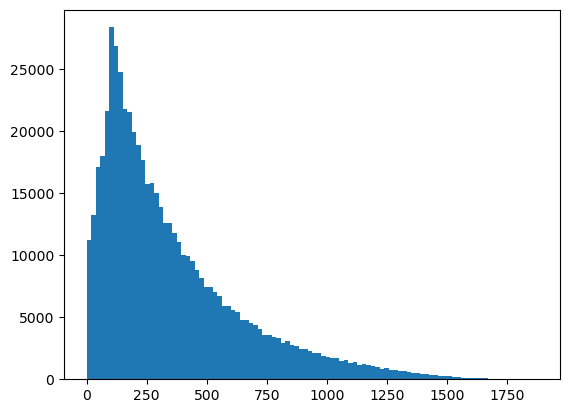

In [2]:
# load generated data
generated_df_list = []

for file in tqdm(os.listdir("./responses")):
    responses = pkl.load(open("./responses/" + file, "rb"))
    texts = []
    reasons = []
    for r in responses:
        if r is not None:
            texts.append(r.choices[0].text)
            reasons.append(r.choices[0].finish_reason)
    generated_df_list.append(pd.DataFrame({"text": texts, "reason": reasons}))

for file in tqdm(os.listdir("./generated")):
    if file.endswith(".csv"):
        generated_df_list.append(pd.read_csv("./generated/" + file))
    elif file.endswith(".pkl"):
        generated_df_list.append(pd.read_pickle("./generated/" + file))

generated_df = pd.concat(generated_df_list).dropna()
generated_df = generated_df[generated_df["reason"] == "stop"]

print(generated_df.shape)
generated_df["length"] = generated_df["text"].progress_apply(
    lambda x: len(str(x).split())
)
plt.hist(generated_df["length"], bins=100)
plt.show()

  0%|          | 0/554623 [00:00<?, ?it/s]

  0%|          | 0/440448 [00:00<?, ?it/s]

(438975, 3)


  0%|          | 0/438975 [00:00<?, ?it/s]

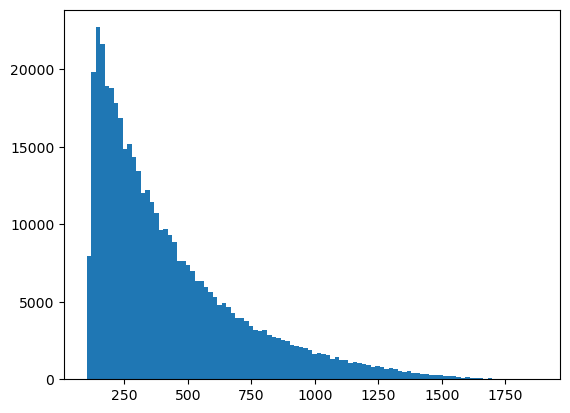

In [3]:
# filter by length
generated_df = generated_df[
    generated_df.text.progress_apply(lambda x: len(str(x)) > 700)
]
generated_df = generated_df[
    generated_df.text.progress_apply(lambda x: len(str(x).split()) > 100)
]

print(generated_df.shape)
generated_df["length"] = generated_df["text"].progress_apply(
    lambda x: len(str(x).split())
)
plt.hist(generated_df["length"], bins=100)
plt.show()

  0%|          | 0/438975 [00:00<?, ?it/s]

  0%|          | 0/438975 [00:00<?, ?it/s]

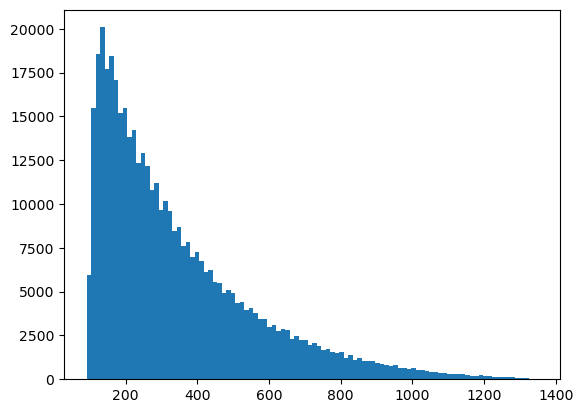

In [4]:
# randomly truncate text to 100-1350 words
generated_df["text"] = generated_df["text"].progress_apply(
    lambda x: " ".join(str(x).split()[10: 10+np.random.randint(100, 1350)])
)
generated_df["length"] = generated_df["text"].progress_apply(
    lambda x: len(str(x).split())
)
plt.hist(generated_df["length"], bins=100)
plt.show()

  0%|          | 0/438975 [00:00<?, ?it/s]

  0%|          | 0/438975 [00:00<?, ?it/s]

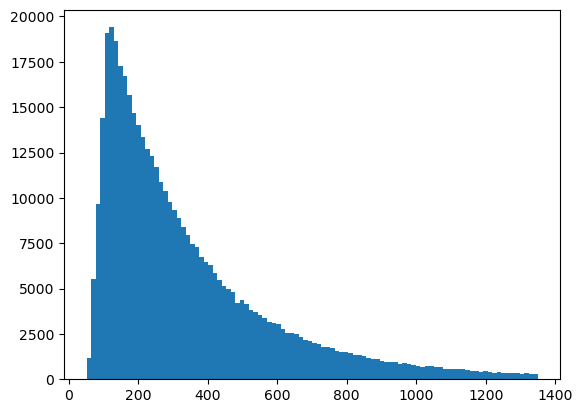

In [5]:
# load human data
human_df = pd.read_csv("./slimpajama.csv").dropna()
human_df = human_df.sample(n=generated_df.shape[0], random_state=42)


def random_truncate(x):
    words = str(x).split()
    start = np.random.randint(0, len(words) // 2)
    end = start + np.random.randint(100, 1350)
    return " ".join(words[start:end])


human_df["text"] = human_df["text"].progress_apply(random_truncate)
human_df["length"] = human_df["text"].progress_apply(lambda x: len(str(x).split()))
plt.hist(human_df["length"], bins=100)
plt.show()

(25390, 11)


  0%|          | 0/25390 [00:00<?, ?it/s]

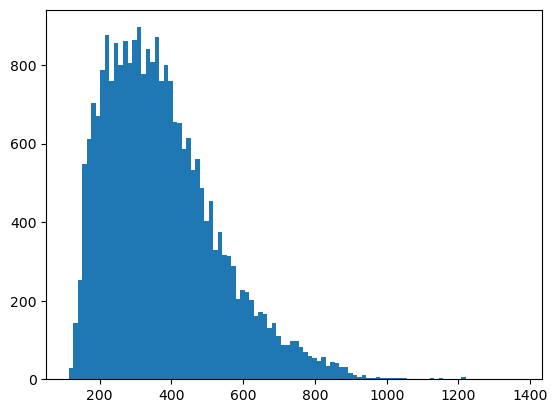

In [6]:
# load persuade dataset
persuade_df = pd.read_csv("../persuade/persuade_combined.csv").dropna()
persuade_df = persuade_df[persuade_df["is_seven"] == True]
print(persuade_df.shape)
persuade_df["length"] = persuade_df["text"].progress_apply(
    lambda x: len(str(x).split())
)
plt.hist(persuade_df["length"], bins=100)
plt.show()

In [7]:
def char_diffs(text1, text2):
    t = set(list("".join(text1)))
    p = set(list("".join(["".join(list(set(e))) for e in text2])))
    chars_to_remove = "".join([x for x in p if x not in t])
    return chars_to_remove


public_train = pd.read_csv("../train_essays.csv")
public_train_essays = public_train["text"].tolist()
combined_essays = persuade_df["text"].tolist()
chars_to_remove = char_diffs(public_train_essays, combined_essays)


for c in chars_to_remove:
    persuade_df["text"] = persuade_df["text"].apply(lambda x: x.replace(c, ""))

### Merge Datasets

In [8]:
persuade_df = persuade_df[["text", "generated"]]
generated_df["generated"] = 1
human_df["generated"] = 0
generated_df = generated_df[["text", "generated"]]
human_df = human_df[["text", "generated"]]

combined_df = pd.concat([persuade_df, generated_df, human_df])
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(combined_df.shape)
combined_df.head()

(903340, 2)


,text,generated
0,"in February 2021 were 113,000 tons, down by 6....",1
1,City boss Lee Hodges is hoping his team can be...,0
2,"of buttons for each team, with 'minus' goal bu...",0
3,repeatedly emphasized during the discussion. I...,0
4,"studios, pirate-themed cupcake shops (“sponsor...",1


In [ ]:
# final cleaning
import unicodedata

def normalize_text(text):
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    return text.strip()

def char_diffs(text1, text2):
    t = set(list("".join(text1)))
    p = set(list("".join(["".join(list(set(e))) for e in text2])))
    chars_to_remove = "".join([x for x in p if x not in t])
    return chars_to_remove

public_train = pd.read_csv("../train_essays.csv")
public_train_essays = public_train["text"].tolist()
combined_essays = combined_df["text"].tolist()
chars_to_remove = char_diffs(public_train_essays, combined_essays)

combined_df["text"] = combined_df["text"].progress_apply(normalize_text)
for c in tqdm(chars_to_remove):
    combined_df["text"] = combined_df["text"].apply(lambda x: x.replace(c, ""))

In [ ]:
combined_df["word_length"] = combined_df["text"].progress_apply(lambda x: len(str(x).split()))
combined_df["char_length"] = combined_df["text"].progress_apply(lambda x: len(str(x)))

In [ ]:
# graph word length distribution of human vs generated
plt.hist(combined_df[combined_df["generated"] == 0]["word_length"], bins=100, range=(0, 300), alpha=0.5, label="human")
plt.hist(combined_df[combined_df["generated"] == 1]["word_length"], bins=100, range=(0, 300), alpha=0.5, label="generated")
plt.legend()
plt.show()

# graph char length distribution of human vs generated
plt.hist(combined_df[combined_df["generated"] == 0]["char_length"], bins=100, range=(0,1000), alpha=0.5, label="human")
plt.hist(combined_df[combined_df["generated"] == 1]["char_length"], bins=100, range=(0,1000), alpha=0.5, label="generated")
plt.legend()
plt.show()

In [ ]:
# filter by length again
combined_df = combined_df[combined_df["char_length"] > 700]

In [9]:
print(combined_df.shape)
print(combined_df["generated"].value_counts())

(903340, 2)
generated
1    451670
0    451670
Name: count, dtype: int64


In [10]:
i = 27
print(combined_df["text"].iloc[i])
print(combined_df["generated"].iloc[i])
print("\\" in combined_df["text"].iloc[i])
combined_df["text"].iloc[i]

to pay respects was well in order. Yet—as with a Lone Pine or beloved tree, say—that can lead to a vandalism/amputation cycle not unlike the one detailed by the City of Richmond in 2009, when they began what has become a regular program of crackdowns on illegal treehouses and swing-sets in the city's parks. Or a jump that lands on the trail, so that they can redo it on the way back. “That's why there are so many dudes out here,” she says. The brown meadow rises up on one side, the descent, steeper and rockier, on the other. Not necessarily known for an overabundance of warm weather or sheer numbers of boulders or snakes, this spot outside Mt. It can stop them from getting to the other side—or at least going straight to it—and finding something new, which can defeat the purpose. From the summit, he went right toward the big red rock—the sort of object that announces itself as you round a bend, as opposed to the almost ludicrous number of mounds of boulders that slip away along the trail

'to pay respects was well in order. Yet—as with a Lone Pine or beloved tree, say—that can lead to a vandalism/amputation cycle not unlike the one detailed by the City of Richmond in 2009, when they began what has become a regular program of crackdowns on illegal treehouses and swing-sets in the city\'s parks. Or a jump that lands on the trail, so that they can redo it on the way back. “That\'s why there are so many dudes out here,” she says. The brown meadow rises up on one side, the descent, steeper and rockier, on the other. Not necessarily known for an overabundance of warm weather or sheer numbers of boulders or snakes, this spot outside Mt. It can stop them from getting to the other side—or at least going straight to it—and finding something new, which can defeat the purpose. From the summit, he went right toward the big red rock—the sort of object that announces itself as you round a bend, as opposed to the almost ludicrous number of mounds of boulders that slip away along the tr

In [ ]:
for i, row in combined_df[(combined_df["generated"] == 1) & (combined_df["word_length"] < 60)].iterrows():
    print(row["text"])
    print(row["generated"])
    print()

In [11]:
combined_df.to_pickle("./combined.pkl")